In [4]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt


In [5]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import os

# Asignar la ruta donde deseas guardar las imágenes
PROJECT_ROOT_DIR = r"C:\Users\ezequ\OneDrive\Documentos\Facultad\Optimizacion\tp1"
CHAPTER_ID = "imagenes"  # El nombre de la capeta donde voy a guardar las imagenes

# Crear la ruta completa donde se guardarán las imágenes
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)



In [6]:
path = r'C:\Users\ezequ\OneDrive\Documentos\Facultad\Aprendizaje Automatico\material-main\tp\01_aprendizaje_supervisado\datos\data.csv'
df = pd.read_csv(path)
#df = pd.read_csv('data.csv')


In [7]:
df['target'].value_counts()

target
0    343
1    157
Name: count, dtype: int64

La relacion entre clases es 157/343 = 0.46 siendo la mayoritaria la clase representada por el 0 por lo que estamos ante un dataset desbalanceado

A priori hacer un split 400 100 para desarrollo validacion suena razonable , estamos dejando 20% de nuestro dataset para validar.

Capaz es un poco mucho ese porcentaje pero creo que eso aseguraria que los resultados obtenidos tendran un poco mas de robustez.

Dentro de desarrollo capaz podemos hacer algo como k folds con k = 4 para sacarle un poco mas el jugo a los datos.

train = 80%
validacion = 20%

In [8]:
def train_test_split(df,train_size=0.8):
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)
    n = df.shape[0]
    cantNeg, cantPos = df['target'].value_counts()
    proporcion = cantPos / n

    cant_en_train = int(n*train_size)
    cant_en_validacion = n - cant_en_train

    res = []
    cant_positivas = int(proporcion * cant_en_validacion)
    cant_negativas = cant_en_validacion - cant_positivas

    contador_positivos, contador_negativos = 0, 0
    for index, value in enumerate(df['target']):
        if value == 0:
            contador_negativos += 1
            res.append(index)

        if contador_negativos == cant_negativas:
            break
    for index, value in enumerate(df['target']):

        if value == 1:
            contador_positivos += 1
            res.append(index)

        if contador_positivos == cant_positivas:
            break

    df_dev = df.loc[~df.index.isin(res)].reset_index(drop=True)
    df_val = df.loc[res].reset_index(drop=True)
    return df_dev,df_val

In [9]:
df_dev , df_val =  train_test_split(df)


# Ejercicio 2

In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, roc_auc_score , average_precision_score
from sklearn.model_selection import cross_val_predict


In [11]:
X_train = df_dev.drop(columns=['target']).values

y_train = df_dev['target'].values

X_val   = df_val.drop(columns=['target']).values

y_val   =  df_val['target'].values

In [12]:
tree_clf = DecisionTreeClassifier(max_depth=3, random_state=51)
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=51)

In [13]:

scoring = ['accuracy', 'roc_auc', 'average_precision']

skf = StratifiedKFold(n_splits=5)

cv_results = cross_validate(tree_clf, X_train, y_train, cv = skf, scoring = scoring,return_train_score = True)

predicted_labels = cross_val_predict(tree_clf, X_train, y_train, cv = skf)

metricas_globales = {'Accuracy Global' : accuracy_score(y_train, predicted_labels),
                     'Auc Global' : roc_auc_score(y_train, predicted_labels),
                      'Average Precision Global' : average_precision_score(y_train, predicted_labels)
}

cv_results.update(metricas_globales)

df_resultados_ej_2_2 = pd.DataFrame({key: cv_results[key] for key in list(cv_results.keys())[3:]})

df_resultados_ej_2_2.index = df_resultados_ej_2_2.index + 1 # asi el indice del df se correponde con el k


In [14]:
df_resultados_ej_2_2

,train_accuracy,test_roc_auc,train_roc_auc,test_average_precision,train_average_precision,Accuracy Global,Auc Global,Average Precision Global
1,0.834375,0.585470,0.770614,0.432637,0.656625,0.695,0.599467,0.386459
2,0.818750,0.732000,0.852706,0.484188,0.713912,0.695,0.599467,0.386459
3,0.825000,0.613455,0.796826,0.404476,0.657074,0.695,0.599467,0.386459
4,0.809375,0.596000,0.854492,0.394547,0.713593,0.695,0.599467,0.386459
5,0.837500,0.705455,0.836928,0.516564,0.733381,0.695,0.599467,0.386459


In [15]:
cv_results.keys()

dict_keys(['fit_time', 'score_time', 'test_accuracy', 'train_accuracy', 'test_roc_auc', 'train_roc_auc', 'test_average_precision', 'train_average_precision', 'Accuracy Global', 'Auc Global', 'Average Precision Global'])

Basado en pagina 288 de Introduction to Machine Learning with Python

In [16]:
alturas = [3, 5, None]
criterios = ["gini", "entropy"]

resultados = {}

for altura in alturas:
    for criterio in criterios:

        tree = DecisionTreeClassifier(max_depth = altura, criterion = criterio, random_state = 51)

        cv_results_grid = cross_validate(tree, X_train, y_train, cv = skf, scoring = 'accuracy', return_train_score = True)

        accuracy_train = cv_results_grid['train_score'].mean()

        accuracy_test =  cv_results_grid['test_score'].mean()



        resultados[(altura, criterio)] = (accuracy_train,accuracy_test)

results_df = pd.DataFrame(resultados.values(), index=resultados.keys(), columns=['Train Score', 'Test Score'])



In [17]:
results_df

Train Score  Test Score
3   gini        0.825000       0.695
    entropy     0.786250       0.670
5   gini        0.930000       0.690
    entropy     0.920625       0.655
NaN gini        1.000000       0.680
    entropy     1.000000       0.645

# Ejercicio 3

In [33]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
import scipy


# Hay que ver en la documentarcion del modelo cada parametro y tirar una distribucion con los valores mas probables
# Si pones una lista la toma como uniforme discreta

# Aca algunos me tiraban error asi que los comente
param_dist = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'splitter': ['best', 'random'],
    'max_depth': scipy.stats.randint(1,40), #puede ser float
    'min_samples_split': scipy.stats.randint(2,20), #puede ser float
    'min_samples_leaf': scipy.stats.randint(1,20),
    #'min_weight_fraction_leaf':scipy.stats.uniform(0,1) ,
    'max_features': scipy.stats.randint(1,20),
    'random_state': [42],
    'max_leaf_nodes': scipy.stats.randint(2,len(X_train)),
    #'min_impurity_decrease': scipy.stats.uniform(0,0.1),
    #'class_weight': {i: scipy.stats.uniform(0,1) for i in range(len(X_train[0]))},
    #'ccp_alpha': scipy.stats.uniform(0,0.1),
}


tree = DecisionTreeClassifier()
n_iter_search = 30    # Esto es la cantidad de configuraciones que pruebo
random_search = RandomizedSearchCV(estimator=tree, param_distributions=param_dist, scoring='roc_auc', cv=skf, n_iter=n_iter_search)
random_search.fit(X_train, y_train)

best_model = random_search.best_estimator_
best_score = random_search.best_score_

print("Best Model:", best_model)
print("Best AUCROC Score:", best_score)



Best Model: DecisionTreeClassifier(criterion='log_loss', max_depth=30, max_features=16,
                       max_leaf_nodes=373, min_samples_leaf=14,
                       min_samples_split=15, random_state=42)
Best AUCROC Score: 0.6335153587153587


In [30]:
from sklearn.neighbors import KNeighborsClassifier

param_dist = {
    'n_neighbors': scipy.stats.randint(1, 30),
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': scipy.stats.randint(1, 50),
    'p': scipy.stats.randint(1, 5),
    'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski'],
    #'metric_params':,
    #'n_jobs':,
}

knn = KNeighborsClassifier()
n_iter_search = 30
random_search = RandomizedSearchCV(estimator=knn, param_distributions=param_dist, scoring='roc_auc', cv=skf, n_iter=n_iter_search)


# random_search.fit(X_train_normalized, y_train)
# Normalizo los datos para knn
from sklearn import preprocessing
X_train_normalized = preprocessing.normalize(X_train.T).T
random_search.fit(X_train_normalized, y_train) # No se xq daba mejor sin normalizar

best_model = random_search.best_estimator_
best_score = random_search.best_score_

print("Best Model:", best_model)
print("Best AUCROC Score:", best_score)


Best Model: KNeighborsClassifier(algorithm='brute', leaf_size=1, n_neighbors=29, p=3,
                     weights='distance')
Best AUCROC Score: 0.7936526288526289


In [63]:
from sklearn.svm import SVC

param_dist_svm = {
    'C': scipy.stats.uniform(0, 10),
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': scipy.stats.randint(1, 6),
    'gamma': ['scale', 'auto' ], #scipy.stats.uniform(0, 1),
    'coef0': scipy.stats.uniform(0, 1),
    'shrinking': [True, False],
    'probability': [True, False],
    'tol': scipy.stats.uniform(0, 0.1),
    'cache_size': scipy.stats.randint(1, 1000),
    #'class_weight': [{0: x, 1: 1 - x} for x in np.linspace(0, 1, 10)],
}

svm = SVC()
n_iter_search = 30
random_search = RandomizedSearchCV(estimator=svm, param_distributions=param_dist_svm, scoring='roc_auc', cv=skf, n_iter=n_iter_search)
random_search.fit(X_train, y_train)

best_model = random_search.best_estimator_
best_score = random_search.best_score_

print("Best Model:", best_model)
print("Best AUCROC Score:", best_score)

best_kernel = random_search.best_params_['kernel']


Best Model: SVC(C=5.704231535216808, cache_size=247, coef0=0.8098744233280207, degree=2,
    kernel='poly', probability=True, tol=0.08308160630486289)
Best AUCROC Score: 0.8858234654234654


In [28]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Aca casi todas me fallan, hay que mejorarlo

param_dist = {
    #'solver': ['svd','lsqr', 'eigen'],
    #'shrinkage': ['auto',None], #scipy.stats.uniform(0, 1),
    #'priors': [],
    #'n_components': scipy.stats.randint(1, min(len(X_train[0,:]), len(X_train[0]-1))),
    'tol': scipy.stats.uniform(0, 0.1)
    #'covariance_estimator':
}


lda = LinearDiscriminantAnalysis()
n_iter_search = 30
random_search = RandomizedSearchCV(estimator=lda, param_distributions=param_dist, scoring='roc_auc', cv=skf, n_iter=n_iter_search)
random_search.fit(X_train, y_train)

best_model = random_search.best_estimator_
best_score = random_search.best_score_

print("Best Model:", best_model)
print("Best AUCROC Score:", best_score)

Best Model: LinearDiscriminantAnalysis(tol=0.06478779935010508)
Best AUCROC Score: 0.7554754726754727


In [27]:
from sklearn.naive_bayes import GaussianNB

param_dist = {
    'var_smoothing': scipy.stats.uniform(0, 1),
    'priors': [None, [0.5, 0.5]],
}

nb = GaussianNB()
n_iter_search = 30
random_search = RandomizedSearchCV(estimator=nb, param_distributions=param_dist, scoring='roc_auc', cv= skf, n_iter=n_iter_search)
random_search.fit(X_train, y_train)

best_model = random_search.best_estimator_
best_score = random_search.best_score_

print("Best Model:", best_model)
print("Best AUCROC Score:", best_score)

Best Model: GaussianNB(priors=[0.5, 0.5], var_smoothing=0.13390261237988021)
Best AUCROC Score: 0.828577984977985


# Ejercicio 4

In [26]:
from sklearn. model_selection import learning_curve

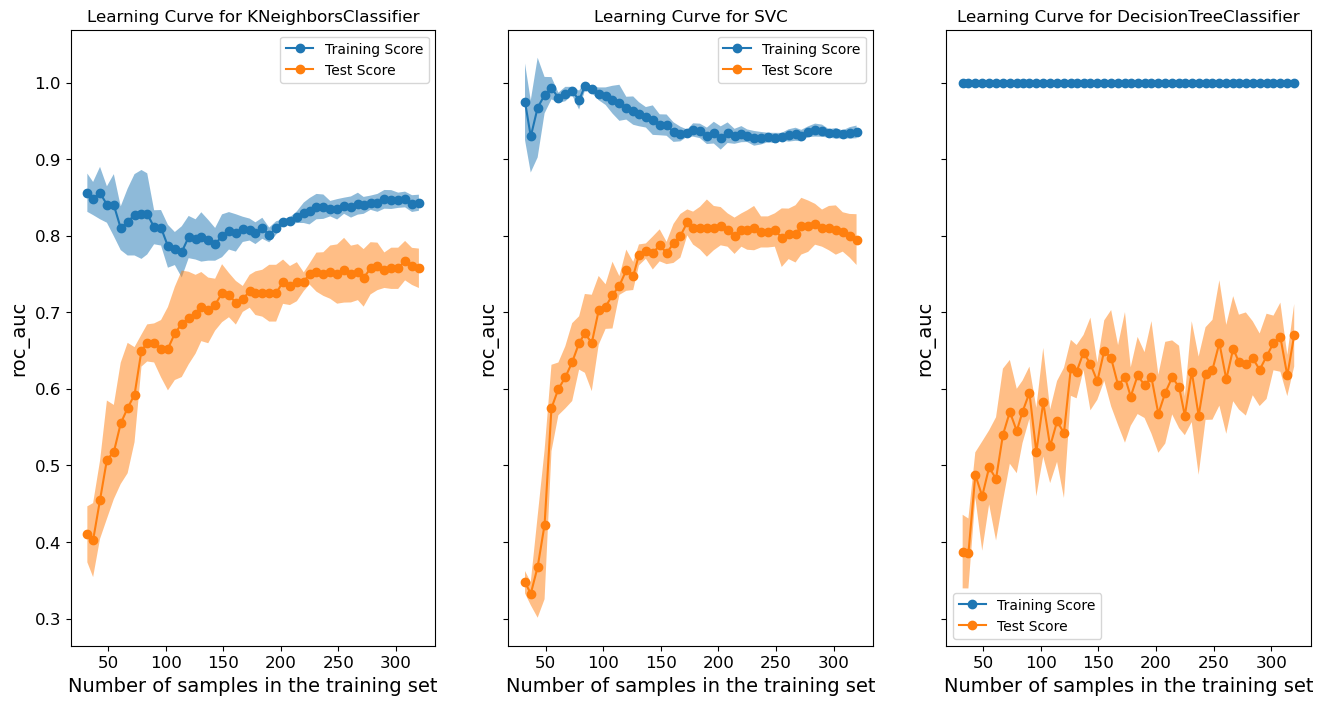

In [72]:
import matplotlib.pyplot as plt
from sklearn.model_selection import LearningCurveDisplay
models = [knn,svm,tree]
fig, ax = plt.subplots(nrows=1, ncols=len(models), figsize=(16, 8), sharey=True)

common_params = {
    "X": X_train,
    "y": y_train,
    "train_sizes": np.linspace(0.1, 1.0, 50),
    "cv": skf,
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "roc_auc",
}

for ax_idx, estimator in enumerate(models):
    LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax[ax_idx])
    handles, label = ax[ax_idx].get_legend_handles_labels()
    ax[ax_idx].legend(handles[:2], ["Training Score", "Test Score"])
    ax[ax_idx].set_title(f"Learning Curve for {estimator.__class__.__name__}")

plt.show()

# Creo que pedia esto me parece raro que no se mueva el hiperparametro en ningun lado 

Todas las celdas para abajo de esta i have no idea what im doing


In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import LearningCurveDisplay
models = [knn,svm,tree]
fig, ax = plt.subplots(nrows=1, ncols=len(models), figsize=(16, 8), sharey=True)

common_params = {
    "X": X_train,
    "y": y_train,
    "train_sizes": np.linspace(0.1, 1.0, 50),
    "cv": skf,
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "roc_auc",
}

for ax_idx, estimator in enumerate(models):
    LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax[ax_idx])
    handles, label = ax[ax_idx].get_legend_handles_labels()
    ax[ax_idx].legend(handles[:2], ["Training Score", "Test Score"])
    ax[ax_idx].set_title(f"Learning Curve for {estimator.__class__.__name__}")

plt.show()

c:\Users\ezequ\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 2 is smaller than n_iter=5. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


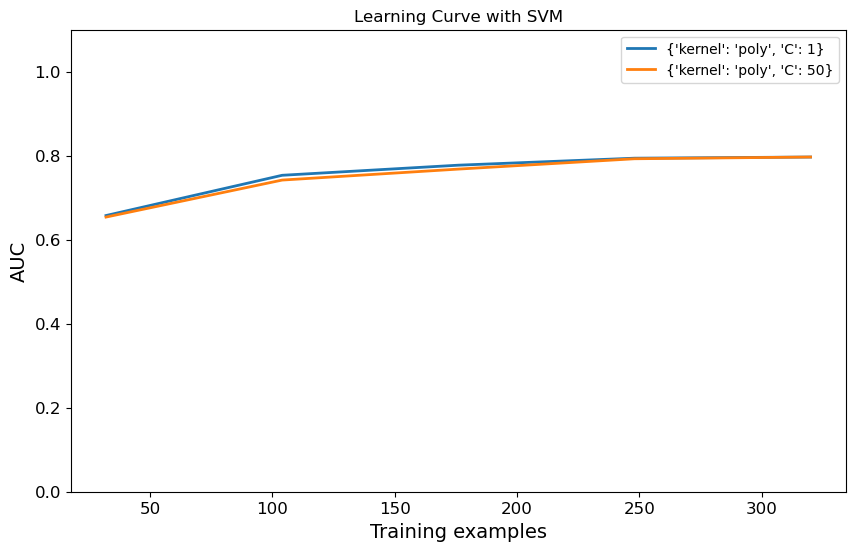

In [75]:
# Parámetros para SVM
param_dist_svm = {
    'C': [1,50],
    'kernel': ['poly']  
}

# Crear y ajustar RandomizedSearchCV para SVM
svm = SVC()
random_search_svm = RandomizedSearchCV(estimator=svm, param_distributions=param_dist_svm, scoring='roc_auc', cv=skf, n_iter=5)
random_search_svm.fit(X_train, y_train)

plt.figure(figsize=(10, 6))
plt.title("Learning Curve with SVM")
plt.xlabel("Training examples")
plt.ylabel("AUC")
plt.ylim(0.0, 1.1)
lw = 2

for _, params in enumerate(random_search_svm.cv_results_['params']):
    estimator = SVC(**params)
    train_sizes, train_scores, test_scores, *_ = learning_curve(estimator, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1)
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    plt.plot(train_sizes, test_scores_mean, label=f"{params}", lw=lw)

plt.legend(loc="best")
plt.show()